# Training Notebook for VQ-VAE

In [10]:
# imports
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import strftime

### Load CelebA dataset

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

Dataset URL: https://www.kaggle.com/datasets/zuozhaorui/celeba
License(s): unknown
100% 2.64G/2.64G [00:01<00:00, 1.24GB/s]
100% 2.64G/2.64G [00:01<00:00, 1.55GB/s]


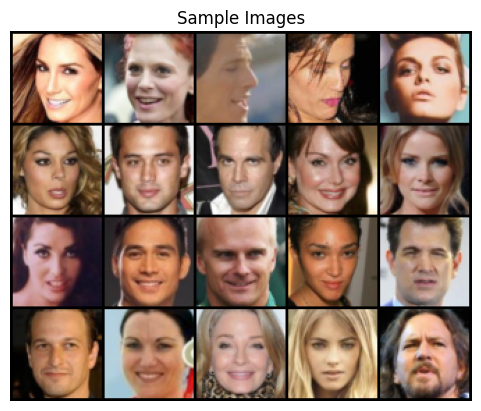

In [4]:
# load dataset
class CelebATransform:
    '''
    Crops around the face and resizes to 64x64. Output is a tensor of shape (3, 64, 64) scaled to [0, 1]
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (64, 64))
        img = torchvision.transforms.functional.to_tensor(img)
        return img
celeba = torchvision.datasets.ImageFolder(root='./data/celeba', transform=CelebATransform())

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x)
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Import model

In [21]:
# clone the github repository containing the VQ-VAE model and import models
# !git clone https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# os.chdir('VQ-VAE-Tranformer-Image-Gen/VQ')
# from model import Encoder, Decoder, Quantizer, VQ_VAE, EMBEDDING_DIM
# os.chdir('../../')

# these are the hyperparameters used in the original VQ-VAE paper (see section 4.1)
HIDDEN_CHANNELS = 256
LATENT_DIM = 8 * 8
EMBEDDING_DIM = 64
NUM_EMBEDDINGS = 512

class ResidualBlock(nn.Module):
    """
    implementation of the residual block as described in section 4.1 of the original VQ-VAE paper\\
    ReLU -> 3x3 conv -> ReLU -> 1x1 conv -> skip connection
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(HIDDEN_CHANNELS, HIDDEN_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(HIDDEN_CHANNELS, HIDDEN_CHANNELS, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.network(x)

class Encoder(nn.Module):
    """
    maps an 64x64 image tensor to a 8x8 latent tensor\\
    downsample -> residual block -> downsample -> residual block -> downsample -> residual block -> 1x1 conv
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # 64x64 image
            nn.Conv2d(in_channels=3, out_channels=HIDDEN_CHANNELS, kernel_size=4, stride=2, padding=1),
            # 32x32 hidden
            ResidualBlock(),
            nn.Conv2d(in_channels=HIDDEN_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=4, stride=2, padding=1),
            # 16x16 hidden
            ResidualBlock(),
            nn.Conv2d(in_channels=HIDDEN_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=4, stride=2, padding=1),
            # 8x8 hidden
            ResidualBlock(),
            nn.Conv2d(in_channels=HIDDEN_CHANNELS, out_channels=EMBEDDING_DIM, kernel_size=1),
            # 8x8 latents
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class Decoder(nn.Module):
    """
    maps a 8x8 quantized latent tensor to an 64x64 image tensor (scaled to [0, 1])\\
    1x1 conv -> residual block -> upsample -> residual block -> upsample -> residual block -> upsample
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # 8x8 latents
            nn.Conv2d(in_channels=EMBEDDING_DIM, out_channels=HIDDEN_CHANNELS, kernel_size=1),
            # 8x8 hidden
            ResidualBlock(),
            nn.ConvTranspose2d(in_channels=HIDDEN_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=4, stride=2, padding=1),
            # 16x16 hidden
            ResidualBlock(),
            nn.ConvTranspose2d(in_channels=HIDDEN_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=4, stride=2, padding=1),
            # 32x32 hidden
            ResidualBlock(),
            nn.ConvTranspose2d(in_channels=HIDDEN_CHANNELS, out_channels=3, kernel_size=4, stride=2, padding=1),
            # 64x64 image
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class Quantizer(nn.Module):
    """
    implementation of the codebook with nearnest neighbor lookup\\
    if use_EMA=True, embeddings are learnt automatically as exponential moving averages of the encoder outputs assigned to them over minibatches (see Appendix A.1 of the original VQ-VAE paper)\\
    otherwise, the embeddings are parameters to be learnt with gradient descent on the codebook loss (see section 3.2 of the original VQ-VAE paper)
    """
    def __init__(self, use_EMA=False, batch_size=0, decay=0.99):
        """
        Args:
            use_EMA (bool): if True, use EMA updates to learn the codebook during training
            batch_size (int): used to initialize the EMA running cluster counts/sums
            decay (float): EMA decay parameter
        """
        super().__init__()
        self.use_EMA = use_EMA

        # codebook dictionary
        if not self.use_EMA:
            self.register_parameter('e', nn.Parameter(torch.randn(NUM_EMBEDDINGS, EMBEDDING_DIM)))
        else:
            self.register_buffer('e', torch.randn(NUM_EMBEDDINGS, EMBEDDING_DIM))

            # EMA running cluster counts and sums
            self.decay = decay
            expected_count = batch_size * LATENT_DIM / NUM_EMBEDDINGS
            self.register_buffer('N', torch.full((NUM_EMBEDDINGS,), expected_count))
            self.register_buffer('m', self.e.clone() * expected_count)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten the embeddings along batch size, height, and width (B, embedding_dim, H, W) -> (BHW, embedding_dim)
        B, _, H, W = x.shape
        z_e_flat = x.permute(0, 2, 3, 1).reshape(-1, EMBEDDING_DIM)

        # to calculate pairwise distance, use ||z - e||^2 = ||z||^2 - 2z*e + ||e||^2
        with torch.no_grad():
            dist = (
                z_e_flat.pow(2).sum(dim=1, keepdim=True) # ||z||^2 (BHW, 1)
                + self.e.pow(2).sum(dim=1).unsqueeze(0)  # ||e||^2 (1, NUM_EMBEDDING)
                - 2 * z_e_flat @ self.e.T                # -2z*e   (BHW, NUM_EMBEDDING)
            )
        indices_flat = dist.argmin(1)

        # EMA codebook update
        if self.use_EMA and self.training:
            # current minibatch cluster counts
            n_i = torch.bincount(indices_flat, minlength=NUM_EMBEDDINGS).float()

            with torch.no_grad():
                # current minibatch cluster sums
                m_i = torch.zeros_like(self.e)
                m_i.index_add_(0, indices_flat, z_e_flat)

                # EMA updates
                self.N = self.decay * self.N + (1 - self.decay) * n_i
                self.m = self.decay * self.m + (1 - self.decay) * m_i
                self.e = self.m / (self.N.unsqueeze(1) + 1e-8)

        z_q = nn.functional.embedding(indices_flat, self.e).view(B, H, W, EMBEDDING_DIM) # (B, H, W, embedding_dim)
        return z_q.permute(0, 3, 1, 2).contiguous()                                      # (B, embedding_dim, H, W)

class VQ_VAE(nn.Module):
    """
        implements the encoder, decoder, and quantizer into a single model for training
    """
    def __init__(self, encoder: Encoder, decoder: Decoder, quantizer: Quantizer, use_EMA=False, beta=0.25):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.quantizer = quantizer
        self.use_EMA = use_EMA
        self.beta = beta

    def compute_latents(self, x: torch.Tensor) -> torch.Tensor:
        """
        64x64 image tensor -> 8x8 quantized latent tensor (without computing gradients)
        """
        with torch.no_grad():
            x = self.encoder(x)
            return self.quantizer(x)

    def reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        """
        64x64 image tensor -> 64x64 reconstructed image tensor (without computing gradients)
        """
        with torch.no_grad():
            x = self.compute_latents(x)
            return self.decoder(x)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor | None]:
        """
        64x64 image tensor -> reconstruction_loss, commitment_loss, codebook_loss\\
        if use_EMA=True, codebook_loss is None
        """
        z_e = self.encoder(x)
        z_q = self.quantizer(z_e)

        # straight through estimator
        z_q_st = z_e + (z_q - z_e).detach()
        reconstructed = self.decoder(z_q_st)

        # compute loss
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, x)
        commitment_loss = nn.functional.mse_loss(z_e, z_q.detach())
        if self.use_EMA:
            codebook_loss = nn.functional.mse_loss(z_e.detach(), z_q)
            return reconstruction_loss, commitment_loss, codebook_loss
        else:
            return reconstruction_loss, commitment_loss, None

### Train model

In [22]:
BATCH_SIZE = 256

# initialize dataloader, models, and optimizer for training
dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
model = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

03:42:16 Begin Training
03:42:23 TRAINING Step [100/15830], Loss: 0.6843
03:42:30 TRAINING Step [200/15830], Loss: 0.6625
03:42:36 TRAINING Step [300/15830], Loss: 0.6586
03:42:42 TRAINING Step [400/15830], Loss: 0.6436
03:42:49 TRAINING Step [500/15830], Loss: 0.6361
03:42:55 TRAINING Step [600/15830], Loss: 0.6150
03:43:02 TRAINING Step [700/15830], Loss: 0.6180
03:43:08 TRAINING Step [800/15830], Loss: 0.6165
03:43:14 TRAINING Step [900/15830], Loss: 0.6117
03:43:21 TRAINING Step [1000/15830], Loss: 0.6118
Checkpoint saved at step 1000 to /content/drive/MyDrive/vq_models/checkpoint.pt


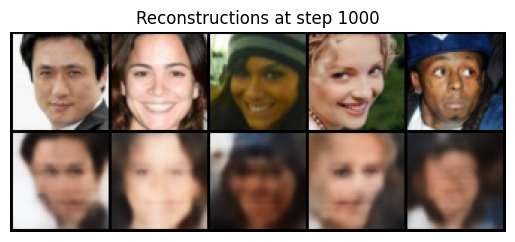

03:43:28 TRAINING Step [1100/15830], Loss: 0.6102
03:43:35 TRAINING Step [1200/15830], Loss: 0.6102
03:43:41 TRAINING Step [1300/15830], Loss: 0.6100
03:43:48 TRAINING Step [1400/15830], Loss: 0.6113
03:43:54 TRAINING Step [1500/15830], Loss: 0.6094
03:44:01 TRAINING Step [1600/15830], Loss: 0.6091
03:44:07 TRAINING Step [1700/15830], Loss: 0.6076
03:44:14 TRAINING Step [1800/15830], Loss: 0.6073
03:44:20 TRAINING Step [1900/15830], Loss: 0.6036
03:44:26 TRAINING Step [2000/15830], Loss: 0.5979
Checkpoint saved at step 2000 to /content/drive/MyDrive/vq_models/checkpoint.pt


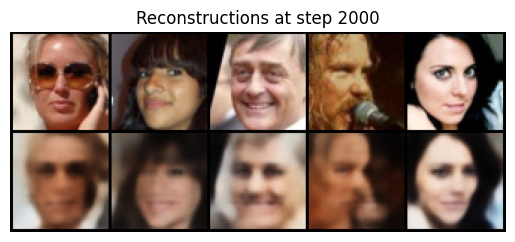

03:44:34 TRAINING Step [2100/15830], Loss: 0.5952
03:44:40 TRAINING Step [2200/15830], Loss: 0.5883
03:44:47 TRAINING Step [2300/15830], Loss: 0.5677
03:44:53 TRAINING Step [2400/15830], Loss: 0.5561
03:44:59 TRAINING Step [2500/15830], Loss: 0.5516
03:45:06 TRAINING Step [2600/15830], Loss: 0.5515
03:45:12 TRAINING Step [2700/15830], Loss: 0.5515
03:45:19 TRAINING Step [2800/15830], Loss: 0.5510
03:45:25 TRAINING Step [2900/15830], Loss: 0.5503
03:45:32 TRAINING Step [3000/15830], Loss: 0.5499
Checkpoint saved at step 3000 to /content/drive/MyDrive/vq_models/checkpoint.pt


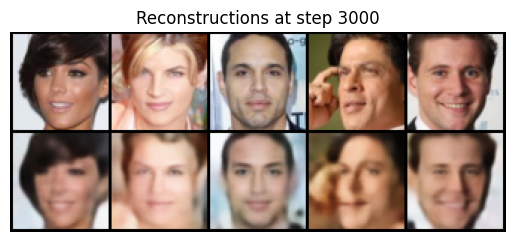

03:45:39 TRAINING Step [3100/15830], Loss: 0.5491
03:45:46 TRAINING Step [3200/15830], Loss: 0.5491
03:45:52 TRAINING Step [3300/15830], Loss: 0.5478
03:45:59 TRAINING Step [3400/15830], Loss: 0.5482
03:46:05 TRAINING Step [3500/15830], Loss: 0.5478
03:46:11 TRAINING Step [3600/15830], Loss: 0.5478
03:46:18 TRAINING Step [3700/15830], Loss: 0.5471
03:46:24 TRAINING Step [3800/15830], Loss: 0.5471
03:46:31 TRAINING Step [3900/15830], Loss: 0.5464
03:46:37 TRAINING Step [4000/15830], Loss: 0.5471
Checkpoint saved at step 4000 to /content/drive/MyDrive/vq_models/checkpoint.pt


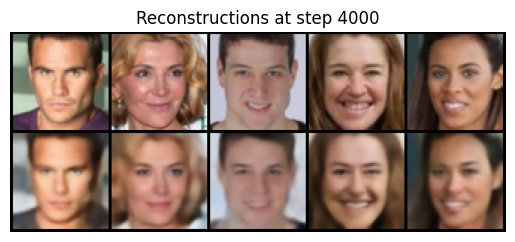

03:46:44 TRAINING Step [4100/15830], Loss: 0.5464
03:46:51 TRAINING Step [4200/15830], Loss: 0.5458
03:46:57 TRAINING Step [4300/15830], Loss: 0.5457
03:47:04 TRAINING Step [4400/15830], Loss: 0.5460
03:47:10 TRAINING Step [4500/15830], Loss: 0.5453
03:47:16 TRAINING Step [4600/15830], Loss: 0.5458
03:47:23 TRAINING Step [4700/15830], Loss: 0.5451
03:47:30 TRAINING Step [4800/15830], Loss: 0.5450
03:47:36 TRAINING Step [4900/15830], Loss: 0.5448
03:47:42 TRAINING Step [5000/15830], Loss: 0.5444
Checkpoint saved at step 5000 to /content/drive/MyDrive/vq_models/checkpoint.pt


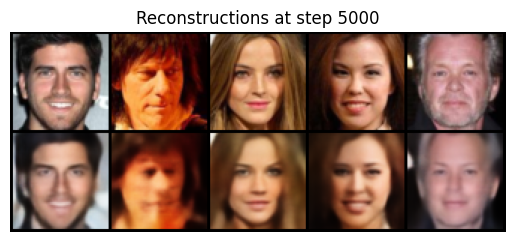

03:47:50 TRAINING Step [5100/15830], Loss: 0.5445
03:47:56 TRAINING Step [5200/15830], Loss: 0.5445
03:48:03 TRAINING Step [5300/15830], Loss: 0.5445
03:48:09 TRAINING Step [5400/15830], Loss: 0.5451
03:48:16 TRAINING Step [5500/15830], Loss: 0.5444
03:48:22 TRAINING Step [5600/15830], Loss: 0.5453
03:48:28 TRAINING Step [5700/15830], Loss: 0.5448
03:48:35 TRAINING Step [5800/15830], Loss: 0.5446
03:48:41 TRAINING Step [5900/15830], Loss: 0.5447
03:48:48 TRAINING Step [6000/15830], Loss: 0.5445
Checkpoint saved at step 6000 to /content/drive/MyDrive/vq_models/checkpoint.pt


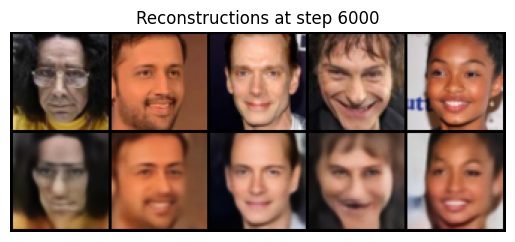

03:48:55 TRAINING Step [6100/15830], Loss: 0.5447
03:49:01 TRAINING Step [6200/15830], Loss: 0.5444
03:49:08 TRAINING Step [6300/15830], Loss: 0.5441
03:49:15 TRAINING Step [6400/15830], Loss: 0.5440
03:49:21 TRAINING Step [6500/15830], Loss: 0.5441
03:49:27 TRAINING Step [6600/15830], Loss: 0.5440
03:49:34 TRAINING Step [6700/15830], Loss: 0.5443
03:49:40 TRAINING Step [6800/15830], Loss: 0.5443
03:49:47 TRAINING Step [6900/15830], Loss: 0.5448
03:49:53 TRAINING Step [7000/15830], Loss: 0.5442
Checkpoint saved at step 7000 to /content/drive/MyDrive/vq_models/checkpoint.pt


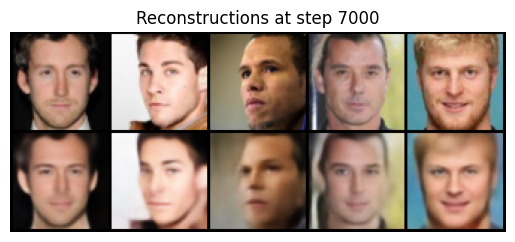

03:50:00 TRAINING Step [7100/15830], Loss: 0.5449
03:50:07 TRAINING Step [7200/15830], Loss: 0.5436
03:50:13 TRAINING Step [7300/15830], Loss: 0.5433
03:50:20 TRAINING Step [7400/15830], Loss: 0.5440
03:50:26 TRAINING Step [7500/15830], Loss: 0.5442
03:50:32 TRAINING Step [7600/15830], Loss: 0.5440
03:50:39 TRAINING Step [7700/15830], Loss: 0.5439
03:50:45 TRAINING Step [7800/15830], Loss: 0.5437
03:50:52 TRAINING Step [7900/15830], Loss: 0.5443
03:50:59 TRAINING Step [8000/15830], Loss: 0.5440
Checkpoint saved at step 8000 to /content/drive/MyDrive/vq_models/checkpoint.pt


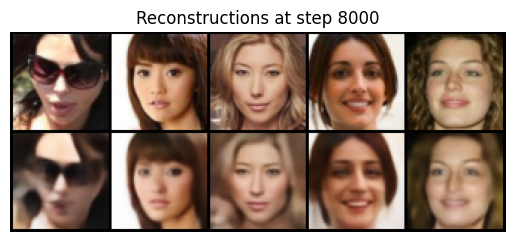

03:51:06 TRAINING Step [8100/15830], Loss: 0.5434
03:51:12 TRAINING Step [8200/15830], Loss: 0.5433
03:51:19 TRAINING Step [8300/15830], Loss: 0.5433
03:51:25 TRAINING Step [8400/15830], Loss: 0.5431
03:51:32 TRAINING Step [8500/15830], Loss: 0.5433
03:51:38 TRAINING Step [8600/15830], Loss: 0.5439
03:51:44 TRAINING Step [8700/15830], Loss: 0.5432
03:51:51 TRAINING Step [8800/15830], Loss: 0.5437
03:51:57 TRAINING Step [8900/15830], Loss: 0.5434
03:52:04 TRAINING Step [9000/15830], Loss: 0.5432
Checkpoint saved at step 9000 to /content/drive/MyDrive/vq_models/checkpoint.pt


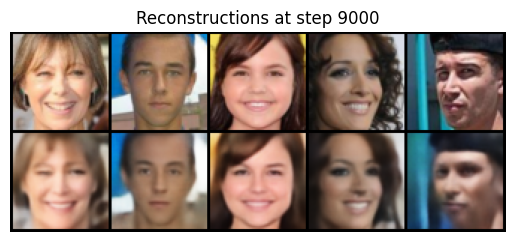

03:52:11 TRAINING Step [9100/15830], Loss: 0.5434
03:52:18 TRAINING Step [9200/15830], Loss: 0.5433
03:52:24 TRAINING Step [9300/15830], Loss: 0.5433
03:52:30 TRAINING Step [9400/15830], Loss: 0.5436
03:52:37 TRAINING Step [9500/15830], Loss: 0.5438
03:52:44 TRAINING Step [9600/15830], Loss: 0.5427
03:52:50 TRAINING Step [9700/15830], Loss: 0.5434
03:52:56 TRAINING Step [9800/15830], Loss: 0.5428
03:53:03 TRAINING Step [9900/15830], Loss: 0.5428
03:53:09 TRAINING Step [10000/15830], Loss: 0.5428
Checkpoint saved at step 10000 to /content/drive/MyDrive/vq_models/checkpoint.pt


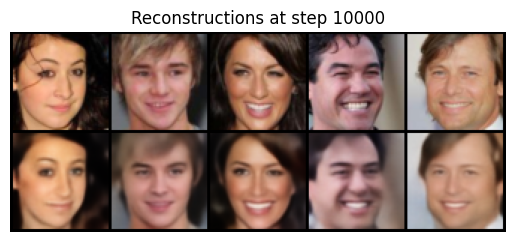

03:53:17 TRAINING Step [10100/15830], Loss: 0.5427
03:53:23 TRAINING Step [10200/15830], Loss: 0.5428
03:53:29 TRAINING Step [10300/15830], Loss: 0.5429
03:53:36 TRAINING Step [10400/15830], Loss: 0.5436
03:53:42 TRAINING Step [10500/15830], Loss: 0.5432
03:53:49 TRAINING Step [10600/15830], Loss: 0.5433
03:53:55 TRAINING Step [10700/15830], Loss: 0.5431
03:54:01 TRAINING Step [10800/15830], Loss: 0.5428
03:54:08 TRAINING Step [10900/15830], Loss: 0.5427
03:54:14 TRAINING Step [11000/15830], Loss: 0.5424
Checkpoint saved at step 11000 to /content/drive/MyDrive/vq_models/checkpoint.pt


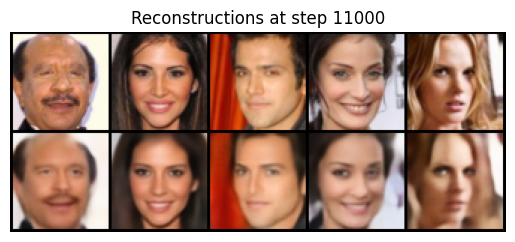

03:54:22 TRAINING Step [11100/15830], Loss: 0.5427
03:54:28 TRAINING Step [11200/15830], Loss: 0.5428
03:54:35 TRAINING Step [11300/15830], Loss: 0.5425
03:54:41 TRAINING Step [11400/15830], Loss: 0.5424
03:54:48 TRAINING Step [11500/15830], Loss: 0.5428
03:54:54 TRAINING Step [11600/15830], Loss: 0.5428
03:55:00 TRAINING Step [11700/15830], Loss: 0.5426
03:55:07 TRAINING Step [11800/15830], Loss: 0.5436
03:55:13 TRAINING Step [11900/15830], Loss: 0.5428
03:55:20 TRAINING Step [12000/15830], Loss: 0.5429
Checkpoint saved at step 12000 to /content/drive/MyDrive/vq_models/checkpoint.pt


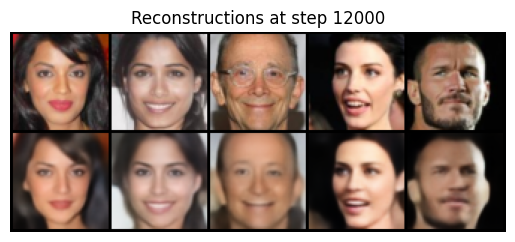

03:55:27 TRAINING Step [12100/15830], Loss: 0.5422
03:55:34 TRAINING Step [12200/15830], Loss: 0.5431
03:55:40 TRAINING Step [12300/15830], Loss: 0.5428
03:55:46 TRAINING Step [12400/15830], Loss: 0.5418
03:55:53 TRAINING Step [12500/15830], Loss: 0.5428
03:55:59 TRAINING Step [12600/15830], Loss: 0.5423
03:56:06 TRAINING Step [12700/15830], Loss: 0.5429
03:56:12 TRAINING Step [12800/15830], Loss: 0.5422
03:56:19 TRAINING Step [12900/15830], Loss: 0.5430
03:56:25 TRAINING Step [13000/15830], Loss: 0.5429
Checkpoint saved at step 13000 to /content/drive/MyDrive/vq_models/checkpoint.pt


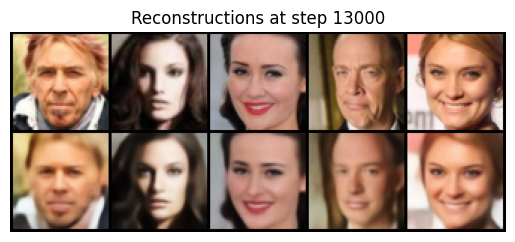

03:56:33 TRAINING Step [13100/15830], Loss: 0.5429
03:56:39 TRAINING Step [13200/15830], Loss: 0.5431
03:56:45 TRAINING Step [13300/15830], Loss: 0.5420
03:56:52 TRAINING Step [13400/15830], Loss: 0.5426
03:56:58 TRAINING Step [13500/15830], Loss: 0.5429
03:57:05 TRAINING Step [13600/15830], Loss: 0.5426
03:57:11 TRAINING Step [13700/15830], Loss: 0.5423
03:57:18 TRAINING Step [13800/15830], Loss: 0.5429
03:57:24 TRAINING Step [13900/15830], Loss: 0.5421
03:57:30 TRAINING Step [14000/15830], Loss: 0.5427
Checkpoint saved at step 14000 to /content/drive/MyDrive/vq_models/checkpoint.pt


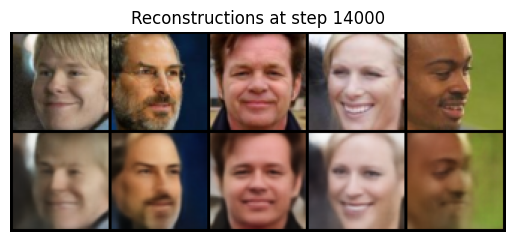

03:57:38 TRAINING Step [14100/15830], Loss: 0.5417
03:57:44 TRAINING Step [14200/15830], Loss: 0.5423
03:57:51 TRAINING Step [14300/15830], Loss: 0.5419
03:57:58 TRAINING Step [14400/15830], Loss: 0.5421
03:58:04 TRAINING Step [14500/15830], Loss: 0.5429
03:58:10 TRAINING Step [14600/15830], Loss: 0.5430
03:58:17 TRAINING Step [14700/15830], Loss: 0.5426
03:58:23 TRAINING Step [14800/15830], Loss: 0.5431
03:58:30 TRAINING Step [14900/15830], Loss: 0.5428
03:58:36 TRAINING Step [15000/15830], Loss: 0.5424
Checkpoint saved at step 15000 to /content/drive/MyDrive/vq_models/checkpoint.pt


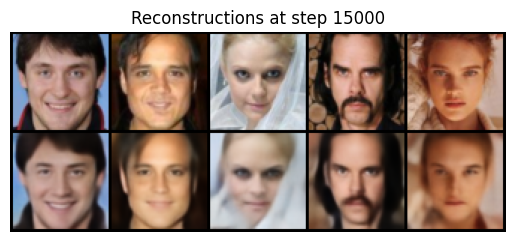

03:58:43 TRAINING Step [15100/15830], Loss: 0.5424
03:58:50 TRAINING Step [15200/15830], Loss: 0.5430
03:58:56 TRAINING Step [15300/15830], Loss: 0.5426
03:59:03 TRAINING Step [15400/15830], Loss: 0.5428
03:59:09 TRAINING Step [15500/15830], Loss: 0.5418
03:59:16 TRAINING Step [15600/15830], Loss: 0.5420
03:59:22 TRAINING Step [15700/15830], Loss: 0.5420
03:59:28 TRAINING Step [15800/15830], Loss: 0.5421
Training complete.


In [23]:
EPOCHS = 10
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
BETA = 0.25

CHECKPOINT_DIR = '/content/drive/MyDrive/vq_models'
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'checkpoint.pt')
LOAD_FROM_CHECKPOINT = False
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

training_losses = []
training_steps = 0
running_losses = [0.0, 0.0, 0.0]

# load from checkpoint
if LOAD_FROM_CHECKPOINT:
    if not os.path.exists(CHECKPOINT_PATH):
        print(f'WARNING: Checkpoint not found at {CHECKPOINT_PATH}!')
    else:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        training_steps = checkpoint['training_steps']
        training_losses = checkpoint['training_losses']
        running_loss = checkpoint['running_loss']
        torch.set_rng_state(checkpoint['cpu_rng_state'])
        if torch.cuda.is_available() and 'cuda_rng_state' in checkpoint:
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])

        print(f'Checkpoint loaded. Resuming from training step {training_steps}.')

total_steps = training_steps + len(dataloader) * EPOCHS

print(f'{strftime('%H:%M:%S')} Begin Training')
model.train()
for epoch in range(EPOCHS):
    for batch in dataloader:
        # training step
        optimizer.zero_grad()
        images, _ = batch
        images = images.to(device)

        reconstruction_loss, commitment_loss, codebook_loss = model(images)
        if model.use_EMA:
            loss = reconstruction_loss + BETA * commitment_loss + codebook_loss
        else:
            loss = reconstruction_loss + BETA * commitment_loss
        loss.backward()
        optimizer.step()
        training_steps += 1

        running_losses[0] += loss.item()
        running_losses[1] += reconstruction_loss.item()
        running_losses[2] += commitment_loss.item()

        # keep track of loss and epoch progress
        if training_steps % LOG_INTERVAL == 0:
            avg_losses = [loss / LOG_INTERVAL for loss in running_losses]
            running_losses = [0.0, 0.0, 0.0]
            training_losses.append((training_steps, avg_losses))
            with torch.no_grad():
                p = model.quantizer.N / model.quantizer.N.sum() * 512
                print(f'{strftime('%H:%M:%S')} TRAINING Step [{training_steps}/{total_steps}]; Loss: {avg_losses[0]:.4f}; Commitment: {avg_losses[2]:.4f}; Usage (min/max/std): {p.min().item():.4f}, {p.max().item():.4f}, {p.std().item():.4f}')

        if training_steps % SAVE_INTERVAL == 0:
            checkpoint = {
                'training_steps': training_steps,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'training_losses': training_losses,
                'running_loss': running_loss,
                'cpu_rng_state': torch.get_rng_state(),
            }
            if torch.cuda.is_available():
                checkpoint['cuda_rng_state'] = torch.cuda.get_rng_state()

            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f'Checkpoint saved at step {training_steps} to {CHECKPOINT_PATH}')

            # visualize reconstructions
            samples, _ = next(iter(dataloader))
            samples = samples[:5].to(device)

            model.eval()
            reconstructed = model.reconstruct(samples)
            model.train()

            img = torchvision.utils.make_grid(torch.cat((samples, reconstructed), dim=0), 5)
            plt.title(f'Reconstructions at step {training_steps}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

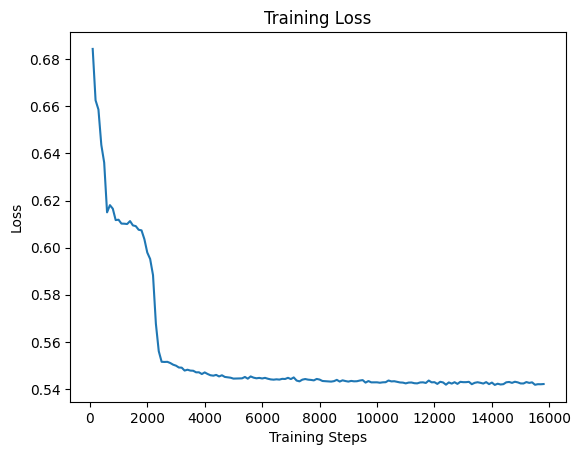

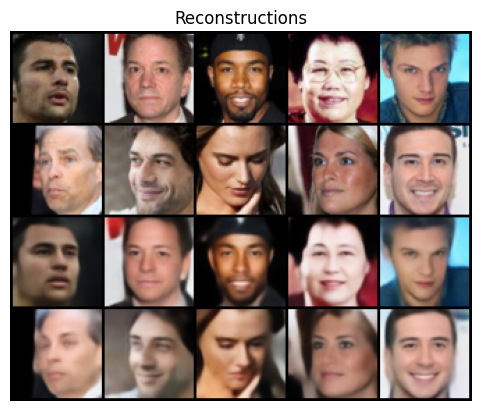

In [37]:
# Convert to numpy arrays for easy slicing
losses_np = np.array(training_losses)
steps = losses_np[:, 0]                     # training steps
losses = np.stack(losses_np[:, 1])          # shape: (num_steps, 3)

plt.plot(steps, losses[:, 0], label='Loss')
plt.plot(steps, losses[:, 1], label='Reconstruction Loss')
plt.plot(steps, losses[:, 2], label='Commitment Loss')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Losses over Training Steps')
plt.legend()
plt.show()

# visualize reconstructions
samples, _ = next(iter(dataloader))
samples = samples[:10].to(device)

model.eval()
reconstructed = model.reconstruct(samples)
model.train()

img = torchvision.utils.make_grid(torch.cat((samples, reconstructed), dim=0), 5)
plt.title(f'Reconstructions')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())
plt.show()